# ------ Import Modules ------

In [1]:
# import necessary modules
import os
import pandas as pd
import numpy as np
import warnings
import json
from machine_learning import MachineLearning, random_tune, xgb_tune, lgb_tune, xgb, lgb
from config import GetDict, SetDict
from feature_importance import FeatureImportance
import h2o
from h2o.automl import H2OAutoML

# suppress warnings
warnings.filterwarnings('ignore')

# ------ Create Models ------

## Base Line Model (Logistic Regression)

In [2]:
# store name to be use in results
model = 'LogisticRegression'

machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)

# set up pre-processing
preprocessing = machine_learning.PreProcessing()

# perform logistic regression
# print out mean squared error and accuracy
mse, score, report = machine_learning.LogisticRegression()

print(f"The accuracy is {report['accuracy']} and precision is {report['1']['precision']} and recall is {report['1']['recall']} and f1 is {report['1']['f1-score']}")

The accuracy is 0.913558013892462 and precision is 0.9388312397596942 and recall is 0.8847143592382913 and f1 is 0.9109697933227344


## Random Forest Classifier Tuning

In [3]:
# store name to be use in results
model = 'RandomForest'

machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)

# set up pre-processing
preprocessing = machine_learning.PreProcessing()

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in random_tune.items():
    # loop through each 
    for value in values:
        
        # set parameter and value to tune
        parameter = { key : value }
        
        # perform random forest
        mse, score, report = machine_learning.RandomForest(parameter_dict=parameter, regressor=False)
        
        results.append((key, value, report['accuracy'], report['1']['precision'], 
                        report['1']['recall'], report['1']['f1-score']))

### Show best results

In [4]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in random_tune.keys():
    
    # get the values for current key
    values = [val for val in results if val[0] == key]
    
    # get the score for current key
    scores = [val[5] for val in values]
    
    # get parameter for current key and max score
    best_score = [val for val in values if val[5] == max(scores)]
    
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]
    
# print best result
print(best_results_dict)
    
# write results to file
file_name = f"{model}_best_results_dict.json"
json_data = json.dumps(best_results_dict)
SetDict(file_name,json_data)

{'max_depth': 50, 'n_estimators': 20, 'max_features': 0.2, 'min_samples_leaf': 1}


### Final, Tuned, Random Forest

In [5]:
# store name to be use in results
model = 'RandomForest'

# call machine learning class
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)
# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")  

# perform random forest using best parameters
mse, score, report = machine_learning.RandomForest(regressor=False, parameter_dict=best_results_dict)

# print final model score
print(f"The accuracy is {report['accuracy']} and precision is {report['1']['precision']} and \
        recall is {report['1']['precision']} and f1 is {report['1']['f1-score']}")

The accuracy is 0.9256496012348855 and precision is 0.9475108225108225 and         recall is 0.9475108225108225 and f1 is 0.9237668161434978


## XgBoost Tuning

In [6]:
# set model name
model = 'XGBoost'

# call machine learning class
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)

# perform pre-processing
preprocessing = machine_learning.PreProcessing()

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in xgb_tune.items():
    # loop through each
    for value in values:

        # set parameter and value to tune
        parameter = {key: value}

        # perform random forst
        mse, score, report = machine_learning.XGboost(regressor=False, parameter_dict=parameter)

        results.append((key, value, report['accuracy'], report['1']['precision'], 
                        report['1']['recall'], report['1']['f1-score']))

[00:09:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:00] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


### Show best results

In [7]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in xgb_tune.keys():
    
    # get the values for current key
    values = [val for val in results if val[0] == key]
    
    # get the score for current key
    scores = [val[5] for val in values]
    
    # get parameter for current key and max score
    best_score = [val for val in values if val[5] == max(scores)]
    
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]
    
# print best result
print(best_results_dict)
    
# write results to file
file_name = f"{model}_best_results_dict.json"
json_data = json.dumps(best_results_dict)
SetDict(file_name,json_data)

{'learning_rate': 0.6, 'max_depth': 10, 'n_estimators': 100}


### Final, Tuned, XgBoost

In [8]:
# set model name
model = 'XGBoost' 

# call machine learning class
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)
 
# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")


# # perform random forest using best parameters
mse, score, report = machine_learning.XGboost(regressor=False, parameter_dict=best_results_dict)
        
# # print final model score
print(f"The accuracy is {report['accuracy']} and precision is {report['1']['precision']} and \
        recall is {report['1']['precision']} and f1 is {report['1']['f1-score']}")

[00:10:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


The accuracy is 0.9279650115770517 and precision is 0.940646528881823 and         recall is 0.940646528881823 and f1 is 0.926892950391645


## LgBoost Tuning

In [9]:
# set model name
model = 'LGBoost'

# call machine learning class
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)
 
# set columns for preprocessing
preprocessing = machine_learning.PreProcessing()

# store results as a list of tuples
results = []

# loop through each paramter and parameter value
for key, values in lgb_tune.items():
    # loop through each 
    for value in values:
        
        # set parameter and value to tune
        parameter = { key : value }
        
        # perform random forst
        mse, score, report = machine_learning.LGboost(regressor=False, parameter_dict=parameter)
        
        results.append((key, value, report['accuracy'], report['1']['precision'], 
                        report['1']['recall'], report['1']['f1-score']))

### Show best results

In [10]:
# store best result to be used as parameter
best_results_dict = {}

# loop through all parameter keys
for key in lgb_tune.keys():

    # get the values for current key
    values = [val for val in results if val[0] == key]
    
    # get the score for current key
    scores = [val[5] for val in values]
    
    # get parameter for current key and max score
    best_score = [val for val in values if val[5] == max(scores)]
    
    # set diction with best parameter and parameter value
    best_results_dict[best_score[0][0]] = best_score[0][1]

# print out results
print(best_results_dict)

# write results to file
file_name = f"{model}_best_results_dict.json"
json_data = json.dumps(best_results_dict)
SetDict(file_name,json_data)

{'learning_rate': 0.2, 'max_depth': 15, 'num_leaves': 31, 'n_estimators': 100, 'min_data_in_leaf': 100}


### Final, Tuned, LgBoost

In [11]:
# set model name
model = 'LGBoost' 

# call machine learning class
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}"),
                                   imbalance=True)
 
# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")  


# perform random forest using best parameters
mse, score, report = machine_learning.LGboost(regressor=False, parameter_dict=best_results_dict)
        
# print final model score
print(f"The accuracy is {report['accuracy']} and precision is {report['1']['precision']} and \
        recall is {report['1']['precision']} and f1 is {report['1']['f1-score']}")

The accuracy is 0.9127862104450734 and precision is 0.9194560669456067 and         recall is 0.9194560669456067 and f1 is 0.9120622568093385


# ------ Test Models ------

## Logistic Regression Cross Validation

In [12]:
# store name to be use in results
model = 'LogisticRegression'

# store results for all models
cv_results = {}

# load data
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"),
                                   imbalance=True)

# setup pre processing
preprocessing=machine_learning.PreProcessing()

# perform random forest using best parameters
info = machine_learning.LogisticRegression(cross_validation=True)

# get max f1 score index
index = np.argmax(info[4])

# get minimum mse and corresponding accuracy
accuracy = info[1][index]
precision = info[2][index]
recall = info[3][index]
f1 = info[4][index]

# store final model score
cv_results[model] = accuracy, precision, recall, f1

## Random Forest Cross Validation

In [13]:
# store name to be use in results
model = 'RandomForest'

# load data
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"),
                                   imbalance=True)

# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")  

# perform random forest using best parameters
info = machine_learning.RandomForest(
    parameter_dict=best_results_dict, regressor=False, cross_validation=True)

# get max f1 score index
index = np.argmax(info[4])

# get minimum mse and corresponding accuracy
accuracy = info[1][index]
precision = info[2][index]
recall = info[3][index]
f1 = info[4][index]

# store final model score
cv_results[model] = accuracy, precision, recall, f1

## XgBoost Forest Cross Validation

In [14]:
# store name to be use in results
model = 'XGBoost'

# load data
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"),
                                   imbalance=True)

# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")  

# perform random forest using best parameters
info = machine_learning.XGboost(
    parameter_dict=best_results_dict, regressor=False, cross_validation=True)

# get max f1 score index
index = np.argmax(info[4])

# get minimum mse and corresponding accuracy
accuracy = info[1][index]
precision = info[2][index]
recall = info[3][index]
f1 = info[4][index]

# store final model score
cv_results[model] = accuracy, precision, recall, f1

[00:10:53] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:54] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:56] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


## LgBoost Forest Cross Validation

In [15]:
# store name to be use in results
model = 'LGBoost'

# load data
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}_CrossValidation"),
                                   imbalance=True)

# setup pre processing
preprocessing = machine_learning.PreProcessing()

# get best_results_dict
best_results_dict = GetDict(f"{model}_best_results_dict.json")  

# perform random forest using best parameters
info = machine_learning.LGboost(
    parameter_dict=best_results_dict, regressor=False, cross_validation=True)

# get max f1 score index
index = np.argmax(info[4])

# get minimum mse and corresponding accuracy
accuracy = info[1][index]
precision = info[2][index]
recall = info[3][index]
f1 = info[4][index]

# store final model score
cv_results[model] = accuracy, precision, recall, f1

## Show model results

In [16]:
# show model results
model_dataframe = pd.DataFrame()
model_dataframe['Model'] = cv_results.keys()
model_dataframe['Accuracy'] = [v[0] for v in cv_results.values()]
model_dataframe['Precision'] = [v[1] for v in cv_results.values()]
model_dataframe['Recall'] = [v[2] for v in cv_results.values()]
model_dataframe['F1'] = [v[3] for v in cv_results.values()]
model_dataframe

,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.806452,0.756392,0.904075,0.823666
1,RandomForest,0.846350,0.809091,0.906621,0.855084
2,XGBoost,0.886624,0.871231,0.907470,0.888981
3,LGBoost,0.814516,0.764832,0.908319,0.830423


## Save results to file

In [17]:
# write dataframe to file
model_dataframe.to_csv(os.path.join('../logs','FinalResults.csv'), index=False)

## Select best model

In [18]:
#select the model with the lowest error as your "production" model
model_dataframe = pd.read_csv(os.path.join('../logs', 'FinalResults.csv'), low_memory=False)
best_model = model_dataframe.loc[model_dataframe['F1'] == max(model_dataframe['F1'])]
best_model

,Model,Accuracy,Precision,Recall,F1
2,XGBoost,0.886624,0.871231,0.90747,0.888981


## Save Final Model

In [19]:
# store name to be use in results
model = best_model['Model'].to_string(index=False).strip()

# load data
machine_learning = MachineLearning(train_data=os.path.join('../data','cleaned','procedure_data.tar.gz'), 
                                   label='UnpaidClaim',
                                   log_file=os.path.join('../logs', f"{model}_FinalModel"),
                                   imbalance=True)

# setup pre processing
preprocessing = machine_learning.PreProcessing()

# choose the best model and save the model
if model == 'LogisticRegression':
    machine_learning.LogisticRegression(save_model=True)
elif model == 'RandomForest':
    best_results_dict = GetDict(f"{model}_best_results_dict.json")  
    machine_learning.RandomForest(
        parameter_dict=best_results_dict, regressor=False, save_model=True)
elif model == 'XGBoost':
    best_results_dict = GetDict(f"{model}_best_results_dict.json")  
    machine_learning.XGboost(parameter_dict=best_results_dict, regressor=False, save_model=True)
elif model == 'LGBoost':
    best_results_dict = GetDict(f"{model}_best_results_dict.json")  
    machine_learning.LGboost(parameter_dict=best_results_dict, regressor=False, save_model=True)
else:
    print(f'{model} not found')

[00:11:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Feature Importance for Best Model

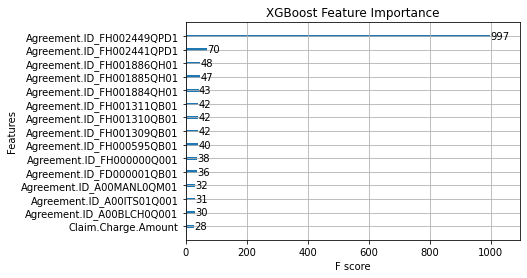

In [20]:
# store name to be use in results
model_name = best_model['Model'].to_string(index=False).strip()

# plot feature importance for the best model
FeatureImportance(model=model_name);
